In [22]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import nltk
import spacy
import gensim.downloader as api
from sklearn.decomposition import PCA
from collections import defaultdict

# Download necessary NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

# Load spaCy model
try:
    nlp = spacy.load('en_core_web_sm')
except:
    print("Installing spaCy model...")
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load('en_core_web_sm')

# Load pre-trained Word2Vec embeddings
print("Loading pre-trained word embeddings...")
word2vec_model = api.load("word2vec-google-news-300")
print("word embeddings loaded successfully")

# Define stop words
stop_words = set(stopwords.words('english'))









Loading pre-trained word embeddings...
word embeddings loaded successfully


In [23]:
def create_dynamic_ontology(df, labels, word2vec_model, min_freq=2, max_terms=50):
    """
    Creates a dynamic ontology from the dataset using word embeddings
    """
    print("Creating dynamic ontology from dataset...")
    G = nx.DiGraph()
    
    # Add category nodes
    for label in labels:
        G.add_node(label, type="category")
    
    category_terms = defaultdict(lambda: defaultdict(int))
    
    # Count term frequencies by category
    for _, row in df.iterrows():
        category = row["label"]
        doc = nlp(row["title"].lower())
        
        for token in doc:
            if (not token.is_stop and token.is_alpha and len(token.text) > 2
                and token.text.lower() not in stop_words):
                category_terms[category][token.lemma_] += 1
    oov_terms = set()  # To track OOV terms

    
    for category, terms in category_terms.items():
        filtered_terms = {}
        
        for term, freq in terms.items():
            if freq >= min_freq:
                if term in word2vec_model:
                    filtered_terms[term] = freq
                else:
                    oov_terms.add(term)  # Mark as OOV
        
        top_terms = sorted(filtered_terms.items(), key=lambda x: -x[1])[:max_terms]
        
        for term, freq in top_terms:
            G.add_node(term, type="concept", frequency=freq)
            G.add_edge(term, category, weight=freq/max(terms.values()), type="belongs_to")
    print(f"Number of OOV terms: {len(oov_terms)}")
    print("Sample OOV terms:", list(oov_terms)[:10])  # Display some OOV terms for debugging

    
    print("Adding semantic similarity edges...")
    nodes = list(G.nodes())
    concepts = [node for node in nodes if G.nodes[node].get('type') == 'concept']
    
    # Only connect terms that are semantically similar
    for i, term1 in enumerate(concepts):
        if i % 50 == 0:
            print(f"Processing term {i}/{len(concepts)}")
        
        for term2 in concepts[i+1:]:
            try:
                if term1 in word2vec_model and term2 in word2vec_model:
                    similarity = word2vec_model.similarity(term1, term2)
                    
                    # Only add edges for highly similar terms
                    if similarity > 0.6:
                        G.add_edge(term1, term2, weight=similarity, type="semantic")
            except:
                continue
    
    print("Identifying semantic subgroups...")
    # Create subgraph of only concept nodes
    concept_subgraph = nx.Graph()
    for term1, term2, data in G.edges(data=True):
        if (G.nodes[term1].get('type') == 'concept' and 
            G.nodes[term2].get('type') == 'concept' and
            data.get('type') == 'semantic'):
            concept_subgraph.add_edge(term1, term2, weight=data['weight'])
    
    # Apply community detection to find subgroups
    try:
        from community import community_louvain
        partition = community_louvain.best_partition(concept_subgraph)
        
        # Create subgroup nodes based on communities
        communities = defaultdict(list)
        for node, community_id in partition.items():
            communities[community_id].append(node)
        
        # Add subgroup nodes for larger communities
        for community_id, members in communities.items():
            if len(members) > 3:  # Only create subgroups with enough members
                top_members = sorted(members,   
                                    key=lambda x: G.nodes[x].get('frequency', 0), 
                                    reverse=True)[:3]
                
                subgroup_name = f"cluster_{community_id}_{'-'.join(top_members[:2])}"
                G.add_node(subgroup_name, type="subgroup")
                
                # Connect members to subgroup
                for member in members:
                    G.add_edge(member, subgroup_name, weight=0.8, type="cluster_member")
                
                # Find categories this cluster relates to
                category_counts = defaultdict(int)
                for member in members:
                    for neighbor in G.neighbors(member):
                        if G.nodes[neighbor].get('type') == 'category':
                            category_counts[neighbor] += 1
                
                # Connect subgroup to top categories
                for category, count in sorted(category_counts.items(), key=lambda x: -x[1])[:2]:
                    strength = count / len(members)
                    G.add_edge(subgroup_name, category, weight=strength, type="cluster_category")
    except ImportError:
        print("Community detection library not available, skipping subgroup identification")
    
    print(f"Dynamic ontology created with {len(G.nodes())} nodes and {len(G.edges())} edges")
    return G

In [24]:
# Feature extraction with embeddings only
class EmbeddingBasedFeatureExtractor:
    def __init__(self, ontology_graph, word2vec_model):
        self.ontology_graph = ontology_graph
        self.word2vec_model = word2vec_model
        self.tfidf = TfidfVectorizer(max_features=3000)
        self.nlp = nlp
        
    def fit(self, X, y=None):
        self.tfidf.fit(X)
        return self
        
    def transform(self, X):
        # Get base TF-IDF features

        X_tfidf = self.tfidf.transform(X)
        
        # Get embedding-based features
        embedding_features = []
        
        # Pre-compute category embeddings
        category_embeddings = {}
        for category in labels:
            category_terms = []
            for pred in self.ontology_graph.predecessors(category):
                if self.ontology_graph.nodes[pred].get('type') == 'concept':
                    category_terms.append(pred)
            
            # Calculate average embedding for category terms
            if category_terms:
                embeddings = []
                for term in category_terms:
                    if term in self.word2vec_model:
                        embeddings.append(self.word2vec_model[term])
                
                if embeddings:
                    category_embeddings[category] = np.mean(embeddings, axis=0)
        
        # Process each document
        for text in X:
            # Initialize similarity scores for each category
            category_scores = {label: 0.0 for label in labels}
            
            # Extract document embedding
            doc = self.nlp(text.lower())
            doc_terms = [token.lemma_ for token in doc if not token.is_stop 
                         and token.is_alpha and len(token.text) > 2]
            
            if doc_terms:
                # Get embeddings for document terms
                term_embeddings = []
                for term in doc_terms:
                    if term in self.word2vec_model:
                        term_embeddings.append(self.word2vec_model[term])
                
                if term_embeddings:
                    # Calculate document embedding as average of term embeddings
                    doc_embedding = np.mean(term_embeddings, axis=0)
                    
                    # Calculate similarity to each category
                    for category, category_embedding in category_embeddings.items():
                        # Use cosine similarity
                        similarity = np.dot(doc_embedding, category_embedding) / (
                            np.linalg.norm(doc_embedding) * np.linalg.norm(category_embedding))
                        category_scores[category] = max(0, similarity)  # Ensure non-negative
            
            # Normalize scores
            total = sum(category_scores.values())
            if total > 0:
                for category in category_scores:
                    category_scores[category] /= total
            
            # Create features array from category scores
            features = np.array([category_scores[label] for label in labels])
            embedding_features.append(features)
        
        # Create sparse matrix from TF-IDF
        tfidf_array = X_tfidf.toarray()
        
        # Combine features
        combined_features = np.hstack((tfidf_array, embedding_features))
        
        return combined_features

In [25]:
# Visualize ontology
def visualize_ontology(G, title="Dynamic Ontology Graph", save_path=None):
    plt.figure(figsize=(18, 14))
    
    # Create layout
    pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)
    
    # Node colors based on type
    node_colors = []
    node_sizes = []
    
    for node in G.nodes():
        node_type = G.nodes[node].get('type', 'concept')
        
        if node_type == 'category':
            node_colors.append('#FF9999')  # Light red
            node_sizes.append(500)
        elif node_type == 'subgroup':
            node_colors.append('#99CCFF')  # Light blue
            node_sizes.append(300)
        else:  # concept
            node_colors.append('#99FF99')  # Light green
            node_sizes.append(150)
    
    # Edge colors based on type
    edges = G.edges(data=True)
    edge_colors = []
    edge_widths = []
    
    for u, v, data in edges:
        edge_type = data.get('type', 'normal')
        if edge_type == 'semantic':
            edge_colors.append('#9370DB')  # Medium purple
            edge_widths.append(1.0)
        elif edge_type == 'cluster_member':
            edge_colors.append('#FF7F50')  # Coral
            edge_widths.append(1.5)
        elif edge_type == 'cluster_category':
            edge_colors.append('#FF4500')  # OrangeRed
            edge_widths.append(2.0)
        else:
            edge_colors.append('#888888')  # Gray
            edge_widths.append(0.5)
    
    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, alpha=0.6)
    
    # Add labels only for important nodes
    labels = {}
    for node in G.nodes():
        node_type = G.nodes[node].get('type', '')
        if node_type in ['category', 'subgroup']:
            labels[node] = node
        elif node_type == 'concept' and len(node) < 10:  # Only show shorter concept names
            labels[node] = node
    
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_weight='bold')
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF9999', markersize=15, label='Category'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#99CCFF', markersize=12, label='Subgroup'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#99FF99', markersize=10, label='Concept'),
        plt.Line2D([0], [0], color='#888888', lw=1, label='Normal Relationship'),
        plt.Line2D([0], [0], color='#9370DB', lw=1.5, label='Semantic Similarity'),
        plt.Line2D([0], [0], color='#FF7F50', lw=2, label='Cluster Membership'),
        plt.Line2D([0], [0], color='#FF4500', lw=2, label='Cluster-Category')
    ]
    
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title(title, fontsize=16)
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        return save_path
    else:
        plt.tight_layout()
        return plt

In [26]:
# Explain prediction using embeddings
def explain_prediction_with_embeddings(text, G, classifier, word2vec_model):
    """
    Explains predictions purely based on semantic similarity to categories via embeddings
    """
    # Process the text
    doc = nlp(text)
    
    # Extract meaningful terms
    terms = [token.lemma_ for token in doc 
             if not token.is_stop and token.is_alpha and len(token.text) > 2]
    
    # Get embeddings for terms
    term_embeddings = []
    terms_with_embeddings = []
    
    for term in terms:
        if term in word2vec_model:
            term_embeddings.append(word2vec_model[term])
            terms_with_embeddings.append(term)
    
    # Make prediction
    prediction = classifier.predict([text])[0]
    probabilities = classifier.predict_proba([text])[0]
    
    # Get category embeddings
    category_embeddings = {}
    category_terms = {}
    
    for category in labels:
        # Get all terms directly connected to this category
        cat_terms = []
        for pred in G.predecessors(category):
            if G.nodes[pred].get('type') == 'concept':
                cat_terms.append(pred)
        
        category_terms[category] = cat_terms
        
        # Calculate average embedding for category terms
        if cat_terms:
            embeddings = []
            for term in cat_terms:
                if term in word2vec_model:
                    embeddings.append(word2vec_model[term])
            
            if embeddings:
                category_embeddings[category] = np.mean(embeddings, axis=0)
    
    # Calculate similarity of each term to each category
    term_category_similarities = {}
    
    if terms_with_embeddings:
        for term, term_embedding in zip(terms_with_embeddings, term_embeddings):
            term_category_similarities[term] = {}
            
            for category, category_embedding in category_embeddings.items():
                # Calculate cosine similarity
                similarity = np.dot(term_embedding, category_embedding) / (
                    np.linalg.norm(term_embedding) * np.linalg.norm(category_embedding))
                term_category_similarities[term][category] = similarity
    
    # Find the most similar terms from each category
    top_category_terms = {}
    
    for category in labels:
        if terms_with_embeddings:
            # Sort terms by similarity to this category
            sorted_terms = sorted([(term, term_category_similarities[term][category]) 
                                 for term in terms_with_embeddings],
                                key=lambda x: -x[1])
            top_category_terms[category] = sorted_terms[:5]  # Top 5 terms
        else:
            top_category_terms[category] = []
    
    # Additional data for visualization
    category_evidence = {}
    for category in labels:
        if category in category_terms:
            # Find the nearest terms from the category to the document
            nearest_terms = []
            
            if terms_with_embeddings:
                # Create document embedding (avg of terms)
                doc_embedding = np.mean(term_embeddings, axis=0)
                
                # Calculate similarity of each category term to the document
                for cat_term in category_terms[category]:
                    if cat_term in word2vec_model:
                        cat_term_emb = word2vec_model[cat_term]
                        similarity = np.dot(doc_embedding, cat_term_emb) / (
                            np.linalg.norm(doc_embedding) * np.linalg.norm(cat_term_emb))
                        nearest_terms.append((cat_term, similarity))
                
                # Sort by similarity
                nearest_terms.sort(key=lambda x: -x[1])
                category_evidence[category] = nearest_terms[:5]  # Top 5 terms
            else:
                category_evidence[category] = []
    
    return {
        "text": text,
        "prediction": prediction,
        "probabilities": {label: prob for label, prob in zip(classifier.classes_, probabilities)},
        "terms": terms_with_embeddings,
        "term_category_similarities": term_category_similarities,
        "top_category_terms": top_category_terms,
        "category_evidence": category_evidence
    }



In [27]:
def visualize_embedding_classification(text, explanation):
    plt.figure(figsize=(12, 8))
    
    # Plot categories and probabilities in top subplot
    plt.subplot(211)
    
    categories = list(explanation["probabilities"].keys())
    values = list(explanation["probabilities"].values())
    
    # Sort by probability
    sorted_indices = np.argsort(values)[::-1]
    categories = [categories[i] for i in sorted_indices]
    values = [values[i] for i in sorted_indices]
    
    # Create bar chart with better color gradient
    colors = plt.cm.Blues(np.linspace(0.5, 0.9, len(categories)))
    bars = plt.bar(range(len(categories)), values, color=colors)
    
    # Set x-ticks to category names
    plt.xticks(range(len(categories)), categories, rotation=45, ha='right')
    
    # Title and labels
    plt.title(f'Predicted Subreddit: {explanation["prediction"]} (Confidence: {explanation["probabilities"][explanation["prediction"]]:.2f})')
    plt.ylabel('Probability')
    plt.ylim(0, 1.1)  # Give extra space for value labels
    plt.xlim(-0.5, len(categories)-0.5)  # Adjust x-axis limits
    
    # Add probability values on bars with better positioning
    for i, (bar, val) in enumerate(zip(bars, values)):
        plt.text(i, val + 0.02, f'{val:.2f}', 
                 ha='center', va='bottom', fontweight='bold')
    
    # Create text area for explanation
    plt.subplot(212)
    plt.axis('off')
    
    info_text = f"Text: '{text}'\n\n"
    info_text += f"Terms with embeddings: {', '.join(explanation['terms'])}\n\n"
    
    # Add top terms for each category
    info_text += "Top terms by similarity to each category:\n"
    for category in categories:
        info_text += f"\n{category.upper()}:\n"
        
        # Terms from input text most similar to this category
        if explanation["top_category_terms"][category]:
            info_text += "  Terms from input most similar to this category:\n"
            for term, similarity in explanation["top_category_terms"][category]:
                info_text += f"    • {term} (similarity: {similarity:.3f})\n"
        
        # Category terms most similar to input text
        if category in explanation["category_evidence"] and explanation["category_evidence"][category]:
            info_text += "  Category terms most similar to input:\n"
            for term, similarity in explanation["category_evidence"][category]:
                info_text += f"    • {term} (similarity: {similarity:.3f})\n"
    
    plt.text(0, 1.0, info_text, fontsize=10, verticalalignment='top')
    
    # Improve layout
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)  # Add more space between subplots
    
    plt.show()

Initializing embedding-based subreddit classifier...
Dataset loaded with 6958 examples across 7 subreddits
Creating dynamic ontology from dataset...
Number of OOV terms: 272
Sample OOV terms: ['coronaviruse', 'ddo', 'devito', 'kilometre', 'escobar', 'reggiani', 'wiseau', 'robinhood', 'sacha', 'niro']
Adding semantic similarity edges...
Processing term 0/241
Processing term 50/241
Processing term 100/241
Processing term 150/241
Processing term 200/241
Identifying semantic subgroups...
Dynamic ontology created with 252 nodes and 450 edges
Generating ontology visualization...
Dynamic ontology visualization saved as 'embedding_ontology_visualization.png'
Training classifier...


c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Enter a text to classify (or type 'exit' to quit):


C:\Users\aruha\AppData\Local\Temp\ipykernel_27044\209878652.py:60: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


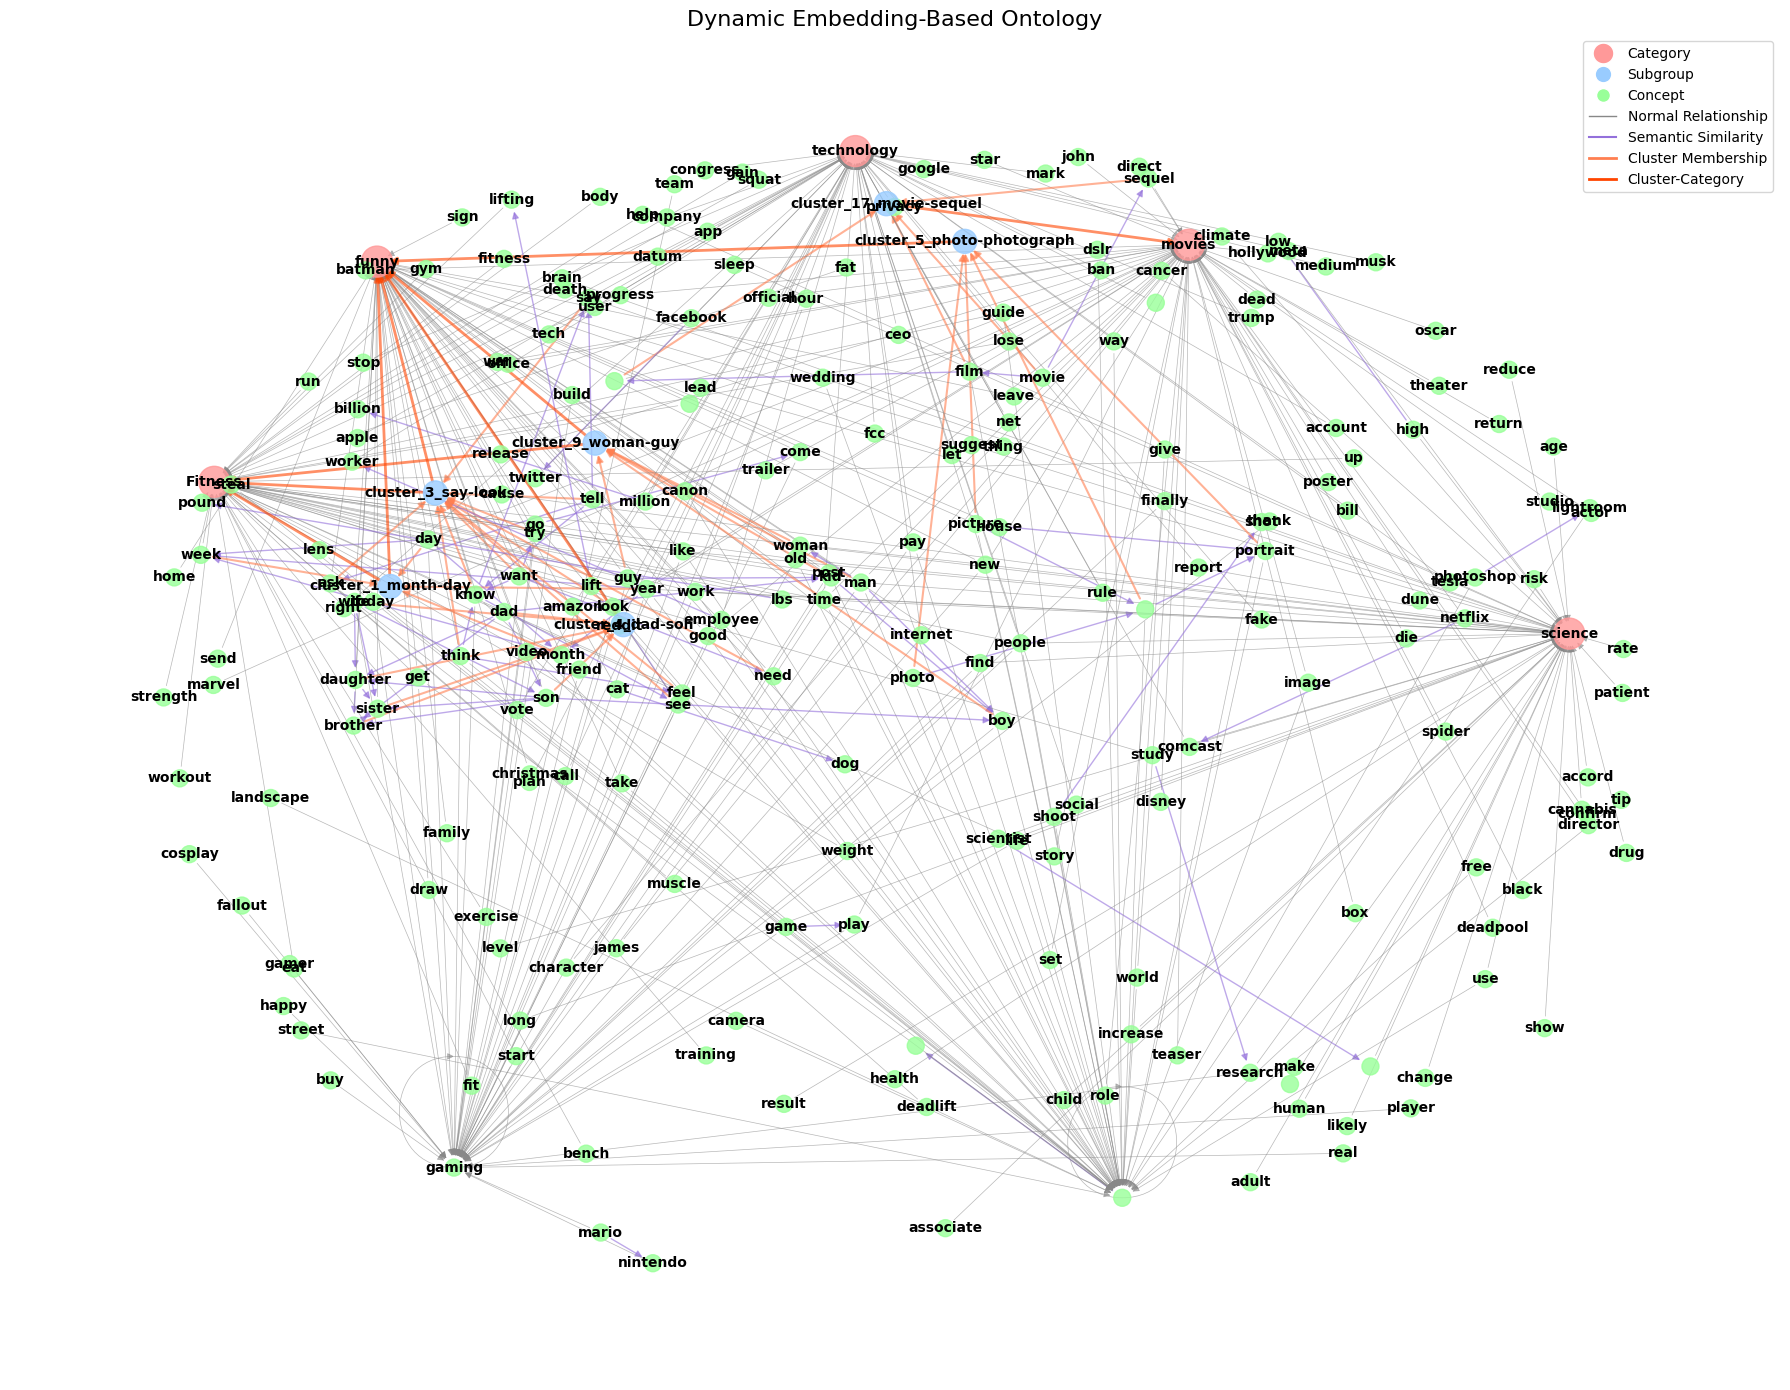

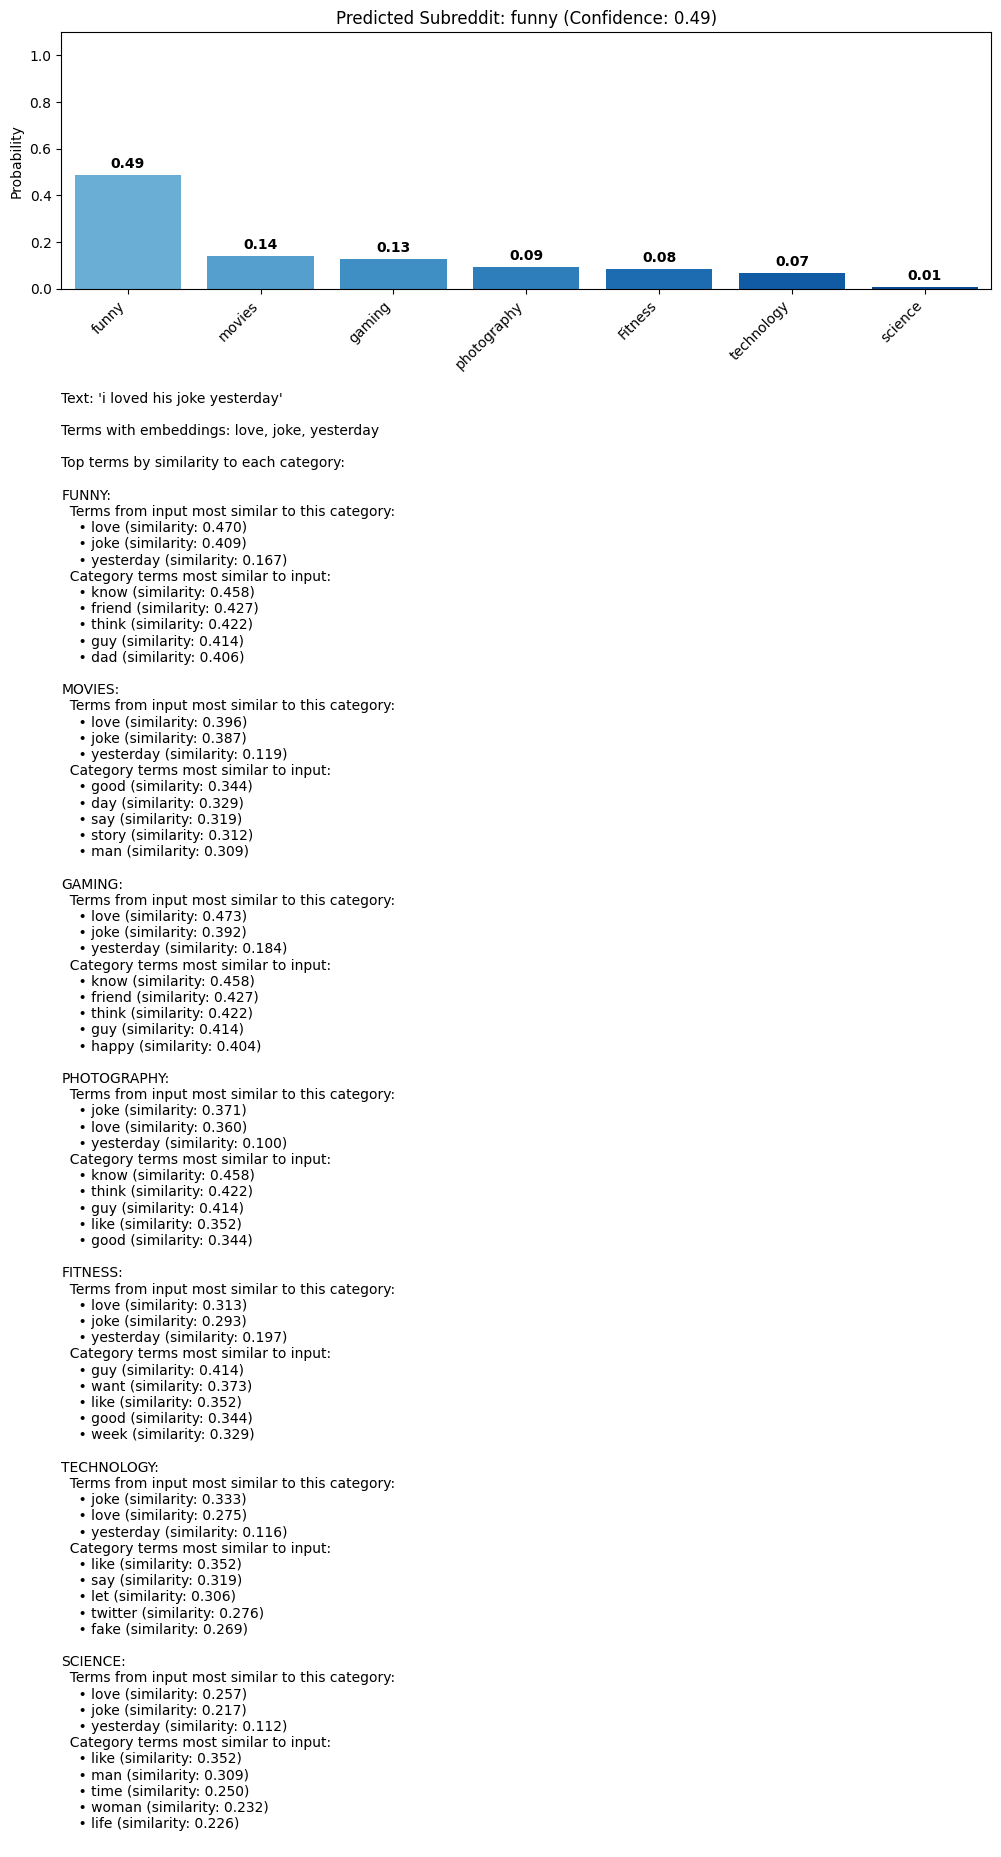


Detailed Classification Results:
Predicted Subreddit: funny

Confidence Scores:
funny: 0.4867
movies: 0.1378
gaming: 0.1275
photography: 0.0920
Fitness: 0.0828
technology: 0.0655
science: 0.0077

Terms with embeddings:
love, joke, yesterday

Top terms by category similarity:

FUNNY:
  Terms from input most similar to this category:
    • love (similarity: 0.470)
    • joke (similarity: 0.409)
    • yesterday (similarity: 0.167)
  Category terms most similar to input:
    • know (similarity: 0.458)
    • friend (similarity: 0.427)
    • think (similarity: 0.422)
    • guy (similarity: 0.414)
    • dad (similarity: 0.406)

MOVIES:
  Terms from input most similar to this category:
    • love (similarity: 0.396)
    • joke (similarity: 0.387)
    • yesterday (similarity: 0.119)
  Category terms most similar to input:
    • good (similarity: 0.344)
    • day (similarity: 0.329)
    • say (similarity: 0.319)
    • story (similarity: 0.312)
    • man (similarity: 0.309)

GAMING:
  Terms from

In [ ]:
# Main function to run everything
def main():
    print("Initializing embedding-based subreddit classifier...")
    
    # Load dataset
    try:
        df = pd.read_csv(r"D:\aravind\A 3RD YEAR STUFF\NLP PROject\predict-subreddit\reddit_data.csv")
    except FileNotFoundError:
        print("Error: reddit_data.csv not found in current directory.")
        file_path = input("Please enter the path to your reddit_data.csv file: ")
        df = pd.read_csv(file_path)
    
    # Define labels
    global labels
    labels = ["technology", "science", "gaming", "Fitness", "movies"]
    df = df[df["label"].isin(labels)]
    
    print(f"Dataset loaded with {len(df)} examples across {len(labels)} subreddits")
    
    # Create dynamic ontology from data
    ontology_graph = create_dynamic_ontology(df, labels, word2vec_model)
    
    # Visualize the ontology
    print("Generating ontology visualization...")
    visualize_ontology(ontology_graph, title="Dynamic Embedding-Based Ontology")
    plt.savefig("embedding_ontology_visualization.png", dpi=300, bbox_inches='tight')
    print("Dynamic ontology visualization saved as 'embedding_ontology_visualization.png'")
    
    # Train-test split
    train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
    
    # Feature extraction with embeddings
    print("Training classifier...")
    embedding_extractor = EmbeddingBasedFeatureExtractor(ontology_graph, word2vec_model)
    
    # Create and train classifier
    embedding_classifier = Pipeline([
        ('features', embedding_extractor),
        ('classifier', LogisticRegression(max_iter=1000, solver="lbfgs", multi_class="multinomial"))
    ])
    
    embedding_classifier.fit(train_data["title"], train_data["label"])
    
    # Evaluate the model
    #y_pred = embedding_classifier.predict(test_data["title"])
    #report = classification_report(test_data["label"], y_pred)
    #print("\nClassification Report:")
    #print(report)
    
    # Interactive loop for text classification
    while True:
        print("\n" + "="*50)
        print("Enter a text to classify (or type 'exit' to quit):")
        text = input("> ")
        
        if text.lower() == 'exit':
            break
        
        # Get explanation
        explanation = explain_prediction_with_embeddings(text, ontology_graph, embedding_classifier, word2vec_model)
        
        # Display results with visualization
        visualize_embedding_classification(text, explanation)
        
        # Print detailed text results
        print("\nDetailed Classification Results:")
        print(f"Predicted Subreddit: {explanation['prediction']}")
        print("\nConfidence Scores:")
        for category, prob in sorted(explanation["probabilities"].items(), key=lambda x: -x[1]):
            print(f"{category}: {prob:.4f}")
        
        print("\nTerms with embeddings:")
        print(", ".join(explanation["terms"]))
        
        print("\nTop terms by category similarity:")
        for category in sorted(explanation["top_category_terms"].keys(),
                             key=lambda x: -explanation["probabilities"].get(x, 0)):
            print(f"\n{category.upper()}:")
            
            # Terms from input text most similar to this category
            if explanation["top_category_terms"][category]:
                print("  Terms from input most similar to this category:")
                for term, similarity in explanation["top_category_terms"][category]:
                    print(f"    • {term} (similarity: {similarity:.3f})")
            
            # Category terms most similar to input text
            if category in explanation["category_evidence"] and explanation["category_evidence"][category]:
                print("  Category terms most similar to input:")
                for term, similarity in explanation["category_evidence"][category]:
                    print(f"    • {term} (similarity: {similarity:.3f})")

if __name__ == "__main__":
    main()